#### All States-USA Houseprices - Dataset 2 - Excercise 1 - Timothy Gregorian

In this analysis, we use a large dataset of housing prices across all states in the United States to identify the main factors that influence property values. The purpose of this dataset is to build a predictive deep learning model that can estimate house prices more accurately due to the higher number of observations compared to the smaller dataset used in the folder "ANN-Regression-Dataset1".

#### Use of AI
 I used AI to generate ideas on how to improve the error metrics (e.g., R², MSE, MAE, RMSE). The AI supported me in identifying possible causes for poor performance (such as dataset quality, feature encoding, scaling, or model architecture) and suggested alternative strategies.

#### Link to Dataset 2
https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

#### Information about the Dataset
This USA Housing Market Dataset contains around 2.2 million rows and 12 columns of real-estate related data, which can be used for housing price predictions.

#### Data Description
The dataset contains thousands of housing records from different U.S. states and includes multiple variables that can affect property prices. Some of the key variables are:

1) brokered_by: Real estate agency or broker responsible for the listing.

2) status: Current status of the property.

3) price: Selling price of the house -> in our case the target variable.

4) bed: Number of bedrooms.

5) bath: Number of bathrooms.

6) acre_lot: Lot size in acres.

7) street: Street address of the property.

8) city: City where the house is located.

9) state: State where the house is located.

10) zip_code: Postal code of the property.

11) house_size: Total living area of the house in square feet.

12) prev_sold_date: Date when the property was previously sold.

This dataset provides a comprehensive view of the U.S. housing market, covering both property characteristics and regional information that can affect house prices.

#### Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import tensorflow as tf
import keras
from keras import layers 


#### Load the Dataset / Handle Missing Values
In this step, we prepared the dataset by removing unnecessary columns and dropping rows with missing values in the main features. Since the dataset was too large, we randomly sampled 500,000 rows to include data from all U.S. states. This gave us a clean and manageable dataset for training the model.

In [2]:

import pandas as pd

data = pd.read_csv("realtor-data.zip.csv")

drop_cols = ["brokered_by", "status", "street", "city", "prev_sold_date"]
data = data.drop(columns=drop_cols)

print("Shape after dropping irrelevant columns:", data.shape)

core_cols = ["price", "bed", "bath", "acre_lot", "house_size", "state", "zip_code"]
data = data.dropna(subset=core_cols)

print("Shape after removing NaN values in core variables:", data.shape)

if len(data) >= 500_000:
    data = data.sample(n=500_000, random_state=7)
else:
    print("Warning -> Less than 500k clean rows available, using all rows instead!")

print("Shape after sampling:", data.shape)



Shape after dropping irrelevant columns: (2226382, 7)
Shape after removing NaN values in core variables: (1360627, 7)
Shape after sampling: (500000, 7)


In [3]:
print("Missing values after cleaning:\n", data.isna().sum())

Missing values after cleaning:
 price         0
bed           0
bath          0
acre_lot      0
state         0
zip_code      0
house_size    0
dtype: int64


In [4]:
data = data.drop_duplicates()
print("Shape after duplicate removal:", data.shape)


Shape after duplicate removal: (485812, 7)


The following code counts the number of housing records of all U.S. states, sorts them in descending order, and stores the results in a new DataFrame for analysis.

In [5]:
state_counts = data['state'].value_counts().sort_values(ascending=False)

print("Number of rows per state:\n", state_counts)

state_df = state_counts.reset_index()
state_df.columns = ['state', 'count']

print("\nShape of state_df:", state_df.shape)
print(state_df.head(10))  

Number of rows per state:
 state
California              60443
Texas                   51936
Florida                 45109
Arizona                 19281
Pennsylvania            18635
New York                18470
Georgia                 17373
Washington              16502
Illinois                16443
Virginia                15658
Ohio                    14717
North Carolina          13365
Maryland                11762
Minnesota               11448
Missouri                10757
Massachusetts           10391
Oklahoma                 9605
Michigan                 8084
Oregon                   7950
New Jersey               7102
Colorado                 6986
Wisconsin                6615
Tennessee                6544
South Carolina           6216
Iowa                     5959
Kentucky                 5722
Alabama                  5275
Louisiana                5222
Idaho                    4264
New Mexico               4254
Indiana                  4208
Arkansas                 4151
Kansas 

In the following code, the variable "Zip_Code" has been transformed into four categories (East, South, North, West) to avoid the model interpreting higher zip codes as inherently better. This categorical grouping provides a more meaningful regional representation for training.

In [6]:
def zipcode_to_region(zipcode):
    if 1 <= zipcode < 30000:
        return "East"
    elif 30000 <= zipcode < 50000:
        return "South"
    elif 50000 <= zipcode < 70000:
        return "North"
    else:
        return "West"

data["Region"] = data["zip_code"].apply(zipcode_to_region)

data = data.drop(columns=["Region_East", "Region_South", "Region_North", "Region_West"], errors="ignore")

data = pd.get_dummies(data, columns=["Region"], drop_first=False)


In [7]:
print("Columns after status encoding:", data.columns.tolist())

Columns after status encoding: ['price', 'bed', 'bath', 'acre_lot', 'state', 'zip_code', 'house_size', 'Region_East', 'Region_North', 'Region_South', 'Region_West']


In [8]:
y = data["price"]
X = data.drop(["price", "zip_code"], axis=1) 

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (485812, 9)
Shape of y: (485812,)


#### Correlation

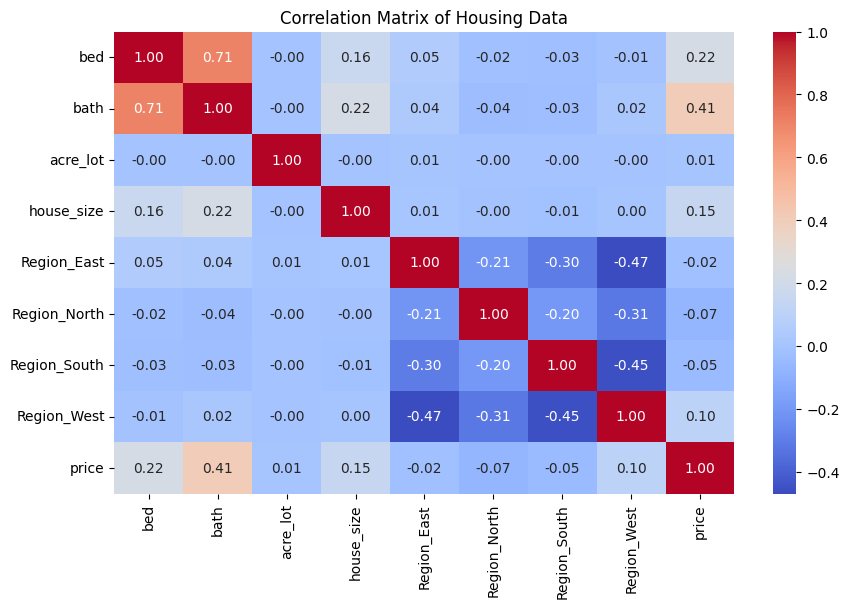

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.join(y).corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Housing Data")
plt.show()


The correlation matrix shows that the number of bedrooms and bathrooms are strongly related, and both have a moderate positive relationship with house prices. Other features, such as lot size and regions, show weak or no clear correlation with price, meaning they contribute less directly to predicting house values.

#### Fisher-Score Test

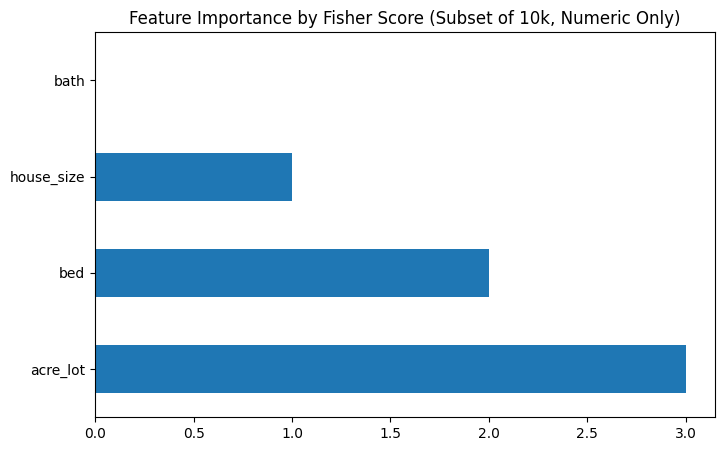

In [10]:
from skfeature.function.similarity_based import fisher_score

X_sub = X.sample(n=10000, random_state=7)
y_sub = y.loc[X_sub.index]

X_sub = X_sub.select_dtypes(include=["number"])

y_binned = pd.qcut(y_sub, q=4, labels=False)

ranks = fisher_score.fisher_score(X_sub.values, y_binned.values)
feat_importances = pd.Series(ranks, index=X_sub.columns)

feat_importances.sort_values(ascending=False).plot(kind="barh", figsize=(8, 5))
plt.title("Feature Importance by Fisher Score (Subset of 10k, Numeric Only)")
plt.show()


The Fisher Score results show that acre_lot and bedrooms are the most influential features for predicting house prices, while house_size has a smaller impact. The number of bathrooms contributes very little, indicating it is less relevant for the model.

#### Chi²-Test

In [11]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

X_num = X.select_dtypes(include=["number"])

X_cat = np.abs(X_num)

y_cat = pd.qcut(y, q=4, labels=False)

chi2_selector = SelectKBest(score_func=chi2, k="all")
chi2_selector.fit(X_cat, y_cat)

chi2_scores = pd.DataFrame({
    "Feature": X_num.columns,
    "Chi2 Score": chi2_selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

print(chi2_scores)


      Feature    Chi2 Score
3  house_size  8.086351e+07
2    acre_lot  5.016364e+05
1        bath  7.320550e+04
0         bed  2.244354e+04


The Chi² test shows that house_size has by far the strongest influence on house prices, followed by acre_lot. In contrast, bathrooms and especially bedrooms have much weaker importance for prediction.

#### VIF-Test

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_vif = X.select_dtypes(include=["number"]).copy()

X_vif = X_vif.astype(float)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


      Feature       VIF
0         bed  8.642917
1        bath  8.846145
2    acre_lot  1.000187
3  house_size  1.309957


The VIF test indicates that bedrooms and bathrooms show high multicollinearity, meaning they carry overlapping information. In contrast, acre_lot and house_size have low VIF values, suggesting they provide independent and unique contributions to the model.

We applied one-hot encoding to the state variable so that all U.S. states could be included in the model without implying any numerical order. This way, the model can treat each state as a separate category for training.

In [13]:
X = pd.get_dummies(X, columns=["state"], drop_first=False)

print("Shape after state encoding:", X.shape)

Shape after state encoding: (485812, 62)


In [14]:
print(X.columns.to_list())

['bed', 'bath', 'acre_lot', 'house_size', 'Region_East', 'Region_North', 'Region_South', 'Region_West', 'state_Alabama', 'state_Alaska', 'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado', 'state_Connecticut', 'state_Delaware', 'state_District of Columbia', 'state_Florida', 'state_Georgia', 'state_Guam', 'state_Hawaii', 'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa', 'state_Kansas', 'state_Kentucky', 'state_Louisiana', 'state_Maine', 'state_Maryland', 'state_Massachusetts', 'state_Michigan', 'state_Minnesota', 'state_Mississippi', 'state_Missouri', 'state_Montana', 'state_Nebraska', 'state_Nevada', 'state_New Hampshire', 'state_New Jersey', 'state_New Mexico', 'state_New York', 'state_North Carolina', 'state_North Dakota', 'state_Ohio', 'state_Oklahoma', 'state_Oregon', 'state_Pennsylvania', 'state_Puerto Rico', 'state_Rhode Island', 'state_South Carolina', 'state_South Dakota', 'state_Tennessee', 'state_Texas', 'state_Utah', 'state_Vermont', 'state

#### Train-/Test-/Validation-Split (70%/15%/15%)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=7
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=7
)

print("Training size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Training size: (340068, 62)
Validation size: (72872, 62)
Test size: (72872, 62)


Here we used StandardScaler to normalize the data, so that all features have the same scale and no variable dominates the model. This ensures more stable and efficient training of the neural network.

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

#### Neural Network Architecture
Here we built a neural network model with several dense layers and batch normalization to improve stability and performance.

In [73]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

variable_amount = len(X.columns)

neural_model_20 = Sequential([
    layers.BatchNormalization(input_shape=(variable_amount,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1)
])

neural_model_20.compile(
    optimizer="adam",
    loss="mse"  
)

neural_model_20.summary()


d:\5. Semester\Deep Learning\DL-projects\venv312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_14          │ (None, 62)             │           248 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,681 (72.97 KB)

 Trainable params: 18,557 (72.49 KB)

 Non-trainable params: 124 (496.00 B)

#### Training the model

Here we used EarlyStopping to monitor the validation loss and stop training if no improvement occurs for 20 epochs. This helps prevent overfitting and ensures the model to be trained in a way for more accurate predictions.

In [74]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",  
    patience=20,         
    restore_best_weights=True
)

mc = ModelCheckpoint(
    'best_model_all_states_dataset-regression.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    verbose=1
)

callback_list = [early_stop, mc, reduce_lr]

history = neural_model_20.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=1024,
    validation_data=(X_val, y_val),
    callbacks=callback_list,
    verbose=1
)

Epoch 1/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1649270456320.0000 - val_loss: 1142906552320.0000 - learning_rate: 0.0010
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1252673454080.0000 - val_loss: 1051828944896.0000 - learning_rate: 0.0010
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1117217751040.0000 - val_loss: 1171780403200.0000 - learning_rate: 0.0010
Epoch 4/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1076736819200.0000 - val_loss: 1184914735104.0000 - learning_rate: 0.0010
Epoch 5/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1035259740160.0000 - val_loss: 1162252910592.0000 - learning_rate: 0.0010
Epoch 6/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1016235819008.0000 - val_loss: 1462850813952.0000 - learning_rate: 0.0010
Epoch 7/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1001826418688.0000 - val_loss: 1427559677952.0000 - learning_rate: 0.0010
Epoch 8/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - 

#### Visualisation / Results

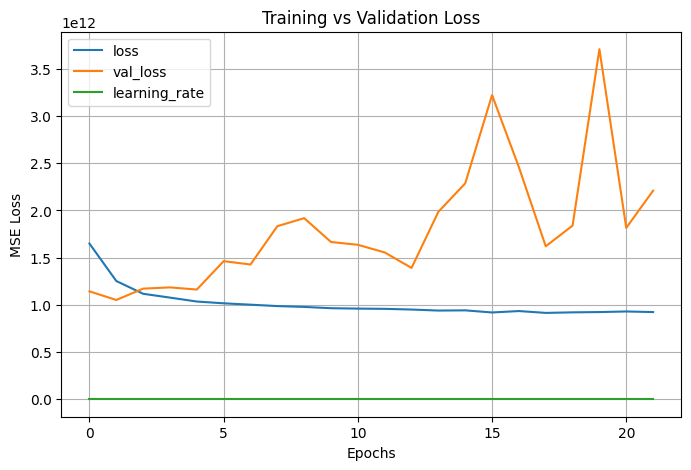

In [75]:
loss_df = pd.DataFrame(neural_model_20.history.history)
loss_df.plot(figsize=(8,5))
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

The plot shows that the training loss remains low and stable, while the validation loss fluctuates heavily with strong spikes. This indicates that the model struggles to generalize well and suffers from instability and possible overfitting.

#### Reload the best version of the model form history

In [76]:
from tensorflow.keras.models import load_model
best_trained_model = load_model("best_model_all_states_dataset-regression.keras")

In [77]:
print("Test data evaluation")
print(best_trained_model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(best_trained_model.evaluate(X_train, y_train, verbose=0))

Test data evaluation
806230622208.0

Train data evaluation:
1233650450432.0


The evaluation results show very high error values for both training and test data. This indicates that the model was not able to learn the patterns in the dataset effectively and delivers poor predictive performance.

In [78]:
import seaborn as sns

test_predictions = best_trained_model.predict(X_test)
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))

pred_df = pd.DataFrame(pd.DataFrame(np.asarray(y_test), columns=["Test True Y"]))
pred_df = pd.concat([pred_df, test_predictions], axis = 1)
pred_df.columns = ["Test True Y", "Model Predictions"]

pred_df


2278/2278 ━━━━━━━━━━━━━━━━━━━━ 2s 734us/step


,Test True Y,Model Predictions
0,600000.0,6.095791e+05
1,1825000.0,1.262954e+06
2,665000.0,3.615979e+05
3,109900.0,4.814730e+05
4,475000.0,9.868028e+05
...,...,...
72867,899000.0,8.996621e+05
72868,284900.0,3.371442e+05
72869,494900.0,1.081260e+06
72870,2195000.0,7.840375e+05


#### Scatterplot

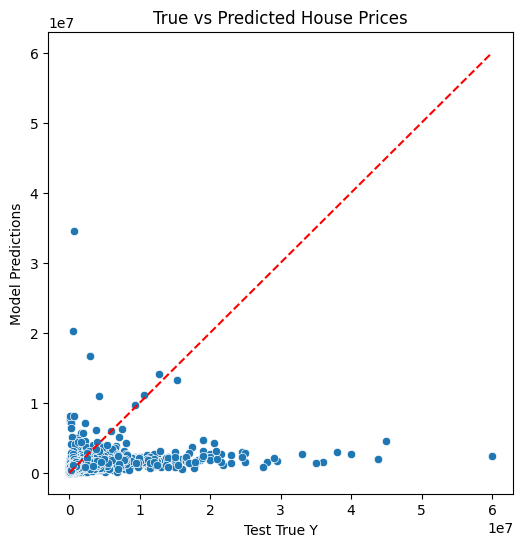

In [79]:
plt.figure(figsize=(6,6))
sns.scatterplot(x="Test True Y", y="Model Predictions", data=pred_df)

min_val = min(pred_df["Test True Y"].min(), pred_df["Model Predictions"].min())
max_val = max(pred_df["Test True Y"].max(), pred_df["Model Predictions"].max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.title("True vs Predicted House Prices")
plt.xlabel("Test True Y")
plt.ylabel("Model Predictions")
plt.show()


The scatterplot shows that most predictions are far from the red diagonal line, which represents perfect accuracy. This indicates that the model has difficulty matching the true house prices and produces many inaccurate predictions.

#### Error-Metrics

In [80]:
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
297191.56 $

MSE
806230561083.79 $^2

RMSE:
897903.43 $

R-squared:
0.19

Explained variance score:
0.19


The evaluation metrics show a very high prediction error (MAE and RMSE) and only a low R² score of 0.19. This means the model explains little of the variance in house prices and struggles to deliver reliable predictions.

C:\Users\Timothy\AppData\Local\Temp\ipykernel_15108\3264322254.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


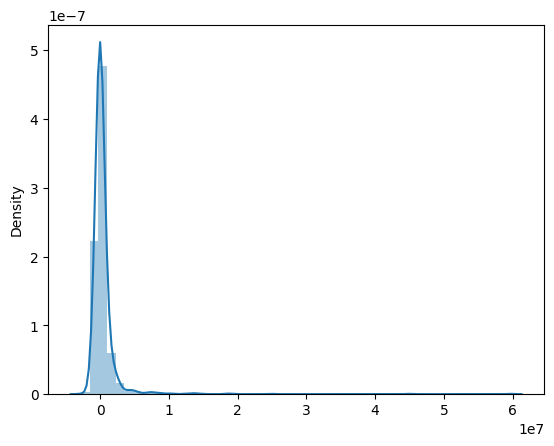

In [81]:
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

The distplot shows that most residuals are concentrated very close to zero, but there are also extreme outliers. This indicates that while the model makes reasonable predictions in many cases, it produces large errors for certain houses.

In [82]:
X.columns

Index(['bed', 'bath', 'acre_lot', 'house_size', 'Region_East', 'Region_North',
       'Region_South', 'Region_West', 'state_Alabama', 'state_Alaska',
       'state_Arizona', 'state_Arkansas', 'state_California', 'state_Colorado',
       'state_Connecticut', 'state_Delaware', 'state_District of Columbia',
       'state_Florida', 'state_Georgia', 'state_Guam', 'state_Hawaii',
       'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Iowa',
       'state_Kansas', 'state_Kentucky', 'state_Louisiana', 'state_Maine',
       'state_Maryland', 'state_Massachusetts', 'state_Michigan',
       'state_Minnesota', 'state_Mississippi', 'state_Missouri',
       'state_Montana', 'state_Nebraska', 'state_Nevada',
       'state_New Hampshire', 'state_New Jersey', 'state_New Mexico',
       'state_New York', 'state_North Carolina', 'state_North Dakota',
       'state_Ohio', 'state_Oklahoma', 'state_Oregon', 'state_Pennsylvania',
       'state_Puerto Rico', 'state_Rhode Island', 'state_South Carolin

In [83]:
X.head(3)

,bed,bath,acre_lot,house_size,Region_East,Region_North,Region_South,Region_West,state_Alabama,state_Alaska,...,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virgin Islands,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
430126,3.0,2.0,1.78,1736.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1754137,3.0,1.0,0.38,1512.0,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1417500,3.0,2.0,0.16,1664.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Prediction-Example

In [84]:
tester_row = {
    "bed": 4,
    "bath": 3,
    "acre_lot": 0.14,
    "house_size": 3054.0,
    "Region_East": 1,
    "Region_North": 0,
    "Region_South": 0,
    "Region_West": 0,

    # states
    'state_Alabama': 0, 
    'state_Alaska': 0,
    'state_Arizona': 0,
    'state_Arkansas': 0,
    'state_California': 0,
    'state_Colorado': 0,
    'state_Connecticut': 0,
    'state_Delaware': 0,
    'state_District of Columbia': 0,
    'state_Florida': 0,
    'state_Georgia': 0,
    'state_Guam': 0,
    'state_Hawaii': 0,
    'state_Idaho': 0,
    'state_Illinois': 0,
    'state_Indiana': 0,
    'state_Iowa': 0,
    'state_Kansas': 0,
    'state_Kentucky': 0,
    'state_Louisiana': 0,
    'state_Maine': 0,
    'state_Maryland': 0,
    'state_Massachusetts': 0,
    'state_Michigan': 0,
    'state_Minnesota': 0,
    'state_Mississippi': 0,
    'state_Missouri': 0,
    'state_Montana': 0,
    'state_Nebraska': 0,
    'state_Nevada': 0,
    'state_New Hampshire': 0,
    'state_New Jersey': 0,
    'state_New Mexico': 0,
    'state_New York': 0,
    'state_North Carolina': 0,
    'state_North Dakota': 0,
    'state_Ohio': 0,
    'state_Oklahoma': 0,
    'state_Oregon': 0,
    'state_Pennsylvania': 0,
    'state_Puerto Rico': 0,
    'state_Rhode Island': 0,
    'state_South Carolina': 0,
    'state_South Dakota': 0, 
    'state_Tennessee': 0,
    'state_Texas': 1,
    'state_Utah': 0,
    'state_Vermont': 0,
    'state_Virgin Islands': 0,
    'state_Virginia': 0,
    'state_Washington': 0,
    'state_West Virginia': 0,
    'state_Wisconsin': 0,
    'state_Wyoming': 0
}

tester_row = pd.DataFrame([tester_row])

tester_row_scaled = scaler.transform(tester_row)

result = best_trained_model.predict(tester_row_scaled)[0][0]

print("Estimated house price: ")
print(f"${round(float(result), 2)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Estimated house price: 
$443766.91


In [85]:
tester_row2 = {
    "bed": 4,
    "bath": 3,
    "acre_lot": 0.14,
    "house_size": 3054.0,
    "Region_East": 0,
    "Region_North": 1,
    "Region_South": 0,
    "Region_West": 0,

    # states
    'state_Alabama': 0, 
    'state_Alaska': 0,
    'state_Arizona': 0,
    'state_Arkansas': 0,
    'state_California': 0,
    'state_Colorado': 0,
    'state_Connecticut': 0,
    'state_Delaware': 0,
    'state_District of Columbia': 0,
    'state_Florida': 0,
    'state_Georgia': 0,
    'state_Guam': 0,
    'state_Hawaii': 0,
    'state_Idaho': 0,
    'state_Illinois': 0,
    'state_Indiana': 0,
    'state_Iowa': 0,
    'state_Kansas': 0,
    'state_Kentucky': 0,
    'state_Louisiana': 0,
    'state_Maine': 0,
    'state_Maryland': 0,
    'state_Massachusetts': 0,
    'state_Michigan': 0,
    'state_Minnesota': 0,
    'state_Mississippi': 0,
    'state_Missouri': 0,
    'state_Montana': 0,
    'state_Nebraska': 0,
    'state_Nevada': 0,
    'state_New Hampshire': 0,
    'state_New Jersey': 0,
    'state_New Mexico': 0,
    'state_New York': 0,
    'state_North Carolina': 0,
    'state_North Dakota': 0,
    'state_Ohio': 0,
    'state_Oklahoma': 0,
    'state_Oregon': 0,
    'state_Pennsylvania': 0,
    'state_Puerto Rico': 0,
    'state_Rhode Island': 0,
    'state_South Carolina': 0,
    'state_South Dakota': 0, 
    'state_Tennessee': 0,
    'state_Texas': 1,
    'state_Utah': 0,
    'state_Vermont': 0,
    'state_Virgin Islands': 0,
    'state_Virginia': 0,
    'state_Washington': 0,
    'state_West Virginia': 0,
    'state_Wisconsin': 0,
    'state_Wyoming': 0
}

tester_row2 = pd.DataFrame([tester_row2])

tester_row_scaled2 = scaler.transform(tester_row2)

result = best_trained_model.predict(tester_row_scaled2)[0][0]

print("Estimated house price: ")
print(f"${round(float(result), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Estimated house price: 
$297375.0


In [86]:
tester_row3 = {
    "bed": 4,
    "bath": 3,
    "acre_lot": 0.14,
    "house_size": 3054.0,
    "Region_East": 0,
    "Region_North": 0,
    "Region_South": 1,
    "Region_West": 0,

    # states
    'state_Alabama': 0, 
    'state_Alaska': 0,
    'state_Arizona': 0,
    'state_Arkansas': 0,
    'state_California': 0,
    'state_Colorado': 0,
    'state_Connecticut': 0,
    'state_Delaware': 0,
    'state_District of Columbia': 0,
    'state_Florida': 0,
    'state_Georgia': 0,
    'state_Guam': 0,
    'state_Hawaii': 0,
    'state_Idaho': 0,
    'state_Illinois': 0,
    'state_Indiana': 0,
    'state_Iowa': 0,
    'state_Kansas': 0,
    'state_Kentucky': 0,
    'state_Louisiana': 0,
    'state_Maine': 0,
    'state_Maryland': 0,
    'state_Massachusetts': 0,
    'state_Michigan': 0,
    'state_Minnesota': 0,
    'state_Mississippi': 0,
    'state_Missouri': 0,
    'state_Montana': 0,
    'state_Nebraska': 0,
    'state_Nevada': 0,
    'state_New Hampshire': 0,
    'state_New Jersey': 0,
    'state_New Mexico': 0,
    'state_New York': 0,
    'state_North Carolina': 0,
    'state_North Dakota': 0,
    'state_Ohio': 0,
    'state_Oklahoma': 0,
    'state_Oregon': 0,
    'state_Pennsylvania': 0,
    'state_Puerto Rico': 0,
    'state_Rhode Island': 0,
    'state_South Carolina': 0,
    'state_South Dakota': 0, 
    'state_Tennessee': 0,
    'state_Texas': 1,
    'state_Utah': 0,
    'state_Vermont': 0,
    'state_Virgin Islands': 0,
    'state_Virginia': 0,
    'state_Washington': 0,
    'state_West Virginia': 0,
    'state_Wisconsin': 0,
    'state_Wyoming': 0
}

tester_row3 = pd.DataFrame([tester_row3])

tester_row_scaled3 = scaler.transform(tester_row3)

result = best_trained_model.predict(tester_row_scaled3)[0][0]

print("Estimated house price: ")
print(f"${round(float(result), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Estimated house price: 
$378752.16


In [87]:
tester_row4 = {
    "bed": 4,
    "bath": 3,
    "acre_lot": 0.14,
    "house_size": 3054.0,
    "Region_East": 0,
    "Region_North": 0,
    "Region_South": 0,
    "Region_West": 1,

    # states
    'state_Alabama': 0, 
    'state_Alaska': 0,
    'state_Arizona': 0,
    'state_Arkansas': 0,
    'state_California': 0,
    'state_Colorado': 0,
    'state_Connecticut': 0,
    'state_Delaware': 0,
    'state_District of Columbia': 0,
    'state_Florida': 0,
    'state_Georgia': 0,
    'state_Guam': 0,
    'state_Hawaii': 0,
    'state_Idaho': 0,
    'state_Illinois': 0,
    'state_Indiana': 0,
    'state_Iowa': 0,
    'state_Kansas': 0,
    'state_Kentucky': 0,
    'state_Louisiana': 0,
    'state_Maine': 0,
    'state_Maryland': 0,
    'state_Massachusetts': 0,
    'state_Michigan': 0,
    'state_Minnesota': 0,
    'state_Mississippi': 0,
    'state_Missouri': 0,
    'state_Montana': 0,
    'state_Nebraska': 0,
    'state_Nevada': 0,
    'state_New Hampshire': 0,
    'state_New Jersey': 0,
    'state_New Mexico': 0,
    'state_New York': 0,
    'state_North Carolina': 0,
    'state_North Dakota': 0,
    'state_Ohio': 0,
    'state_Oklahoma': 0,
    'state_Oregon': 0,
    'state_Pennsylvania': 0,
    'state_Puerto Rico': 0,
    'state_Rhode Island': 0,
    'state_South Carolina': 0,
    'state_South Dakota': 0, 
    'state_Tennessee': 0,
    'state_Texas': 1,
    'state_Utah': 0,
    'state_Vermont': 0,
    'state_Virgin Islands': 0,
    'state_Virginia': 0,
    'state_Washington': 0,
    'state_West Virginia': 0,
    'state_Wisconsin': 0,
    'state_Wyoming': 0
}

#1947223

tester_row4 = pd.DataFrame([tester_row4])

tester_row_scaled4 = scaler.transform(tester_row4)

result = best_trained_model.predict(tester_row_scaled4)[0][0]

print("Estimated house price: ")
print(f"${round(float(result), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Estimated house price: 
$566053.94


#### Model Evaluation and Prediction Analysis
The house from row "1947223" from the CSV-dataset in Texas sold for 508,955.00. When predicting the same property with only the regional indicator changed, the model produced values ranging from 297,375.00 (North) to $566,053.94 (West). While the West prediction came closest to the actual price, the others deviated significantly, especially the North region which underestimated the value. This shows that the model is strongly influenced by regional encoding but does not yet predict prices consistently with the true market value.

#### Conclusion and Challenges
At the beginning, I faced some challenges with scaling the dataset, especially because it included all U.S. states and the Zip_Code variable, which could not simply be treated as numeric. By transforming the zip codes into regions and applying one-hot encoding for the states, the data became much more suitable for training. Another difficulty was designing the right model architecture, as my first attempts resulted in negative R² values, meaning the model performed worse than a baseline. Through multiple tests and adjustments, I was finally able to achieve a positive R² score, showing some improvement.

The relatively low R² value of 0.19 is, in my opinion, mainly due to the dataset quality and structure rather than the model itself. The data may contain noise, outliers, or missing relevant features, which limits how well any model can explain house price variance. In working life, linear regression and similar predictive models can still be very useful for price estimation, risk assessment, or forecasting trends. This project required careful preprocessing and parameter tuning to get meaningful results. For further optimization, I would consider adding more feature engineering, by creating other variables to create a more qualitative dataset, trying different neural network architectures, and possibly using a different scaling method (Regularisation, etc.).